# GECCO2018 Water Quality — Notebook 02: Time-Aware Visualizations

Este notebook foca em visualizações orientadas a série temporal do dataset GECCO2018.

Objetivos:
- Carregar o dataset e aplicar limpezas básicas (parse de `Time`, coerção de tipos, remoção de nulos).
- Visualizar séries temporais das variáveis sensoriais com indicação de `EVENT`.
- Explorar distribuições e correlações entre sensores.
- Salvar figuras principais em `reports/figures/`.

In [1]:
# Ensure project root on sys.path for `import src.*`
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
print("sys.path bootstrapped with:", PROJECT_ROOT)

sys.path bootstrapped with: /home/nelso/Documents/IA - Detecção Falhas


In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils.paths import ensure_directories_exist, FIGURES_DIR
from src.data.loaders import load_gecco2018_csv

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 5)

In [3]:
# Ensure data/ and reports/figures directories exist
ensure_directories_exist()
print("FIGURES_DIR:", FIGURES_DIR)

FIGURES_DIR: /home/nelso/Documents/IA - Detecção Falhas/reports/figures


In [4]:
# Load dataset
try:
    df = load_gecco2018_csv()
except FileNotFoundError as e:
    print(e)
    raise

print(df.shape)
df.head(10)

(139566, 12)


,Unnamed: 0,Time,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2,EVENT
0,1,2016-08-03 11:49:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,False
1,2,2016-08-03 11:50:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,False
2,3,2016-08-03 11:51:00,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,False
3,4,2016-08-03 11:52:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,False
4,5,2016-08-03 11:53:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,False
5,6,2016-08-03 11:54:00,6.5,0.17,8.35,749.0,211.0,0.012,0.118,1553.0,689.0,False
6,7,2016-08-03 11:55:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1552.0,695.0,False
7,8,2016-08-03 11:56:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1603.0,694.0,False
8,9,2016-08-03 11:57:00,6.5,0.17,8.34,749.0,211.0,0.011,0.120,1559.0,700.0,False
9,10,2016-08-03 11:58:00,6.5,0.17,8.34,749.0,211.0,0.011,0.118,1604.0,690.0,False


In [5]:
# Basic cleaning: drop unnamed, parse time, coerce types, drop nulls
# Drop unnamed index column if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Parse Time
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")

# Coerce numeric columns
numeric_cols = ["Tp", "Cl", "pH", "Redox", "Leit", "Trueb", "Cl_2", "Fm", "Fm_2"]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Ensure EVENT is boolean
if df["EVENT"].dtype != bool:
    df["EVENT"] = df["EVENT"].astype(str).str.lower().isin(["true", "1", "t", "yes"])

# Drop rows with nulls in Time or numeric sensors
df_clean = df.dropna(subset=["Time"] + numeric_cols)

# Sort by time and set index
df_clean = df_clean.sort_values("Time").reset_index(drop=True)
df_ts = df_clean.set_index("Time").sort_index()

print("After cleaning:", df_ts.shape)
df_ts.head(5)

After cleaning: (138521, 10)


,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2,EVENT
Time,,,,,,,,,,
2016-08-03 11:49:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,False
2016-08-03 11:50:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,False
2016-08-03 11:51:00,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,False
2016-08-03 11:52:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,False
2016-08-03 11:53:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,False


In [6]:
# Info and missingness check
print(df_ts.info())
df_ts.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138521 entries, 2016-08-03 11:49:00 to 2016-11-08 08:54:00
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Tp      138521 non-null  float64
 1   Cl      138521 non-null  float64
 2   pH      138521 non-null  float64
 3   Redox   138521 non-null  float64
 4   Leit    138521 non-null  float64
 5   Trueb   138521 non-null  float64
 6   Cl_2    138521 non-null  float64
 7   Fm      138521 non-null  float64
 8   Fm_2    138521 non-null  float64
 9   EVENT   138521 non-null  bool   
dtypes: bool(1), float64(9)
memory usage: 10.7 MB
None


Tp       0
Cl       0
pH       0
Redox    0
Leit     0
Trueb    0
Cl_2     0
Fm       0
Fm_2     0
EVENT    0
dtype: int64

In [ ]:
# Event count and timeframe
print("EVENT true count:", int(df_ts["EVENT"].sum()))
print("Time range:", df_ts.index.min(), "->", df_ts.index.max())

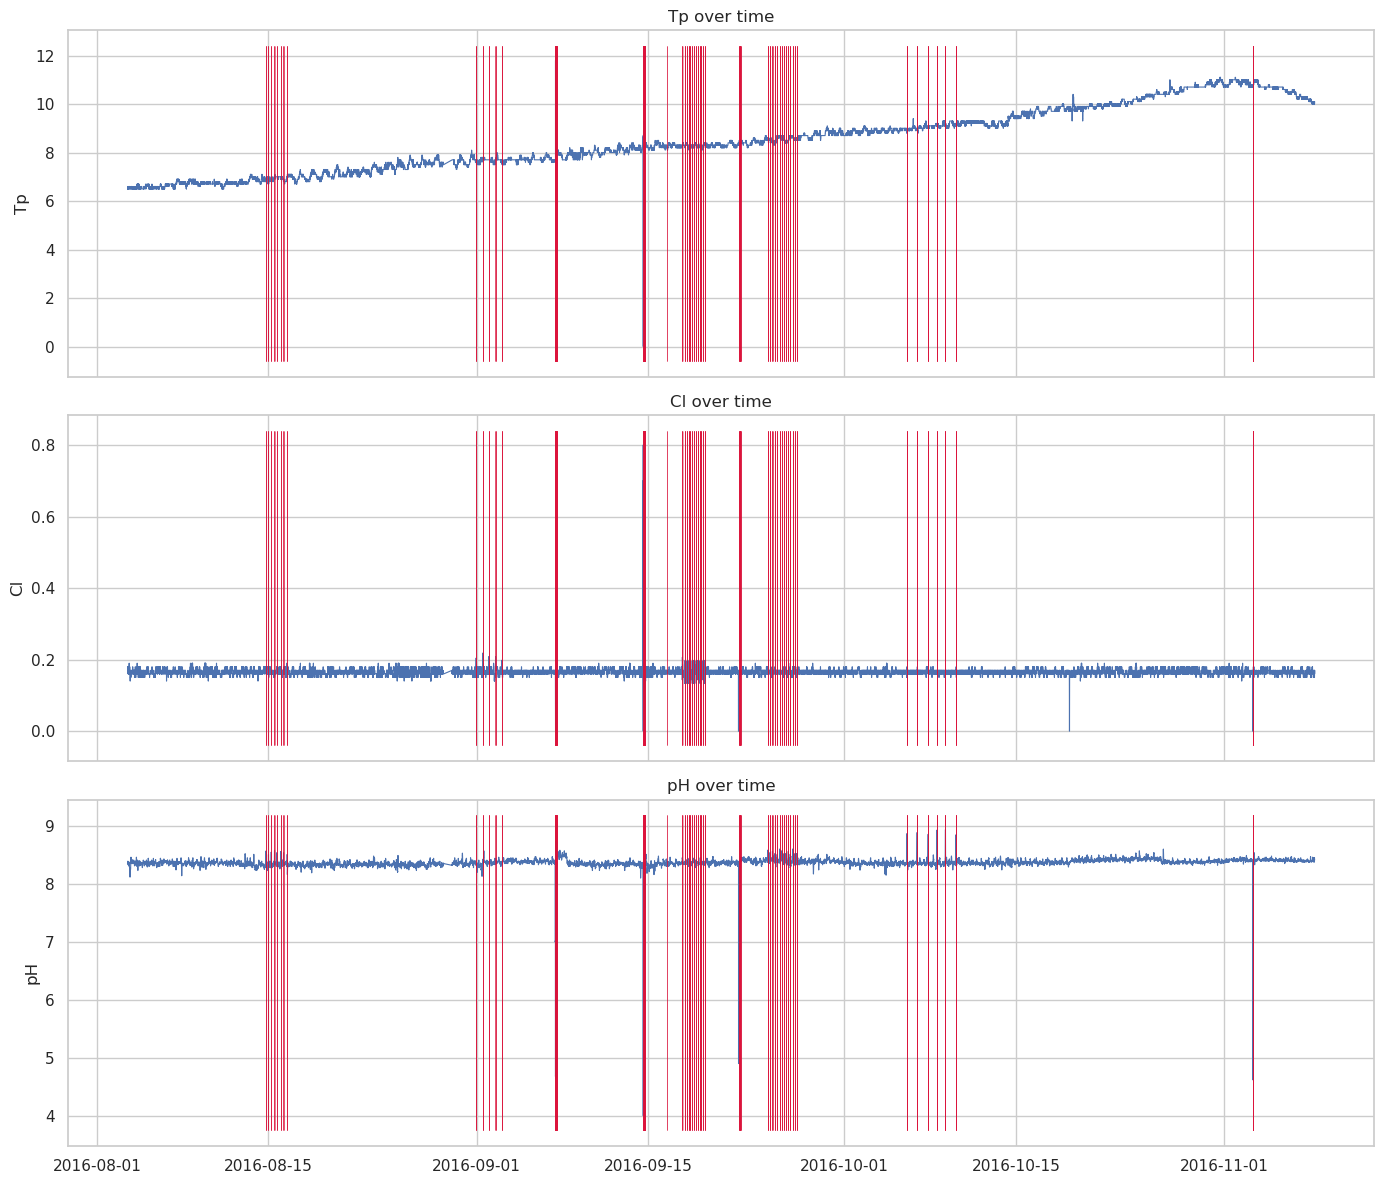

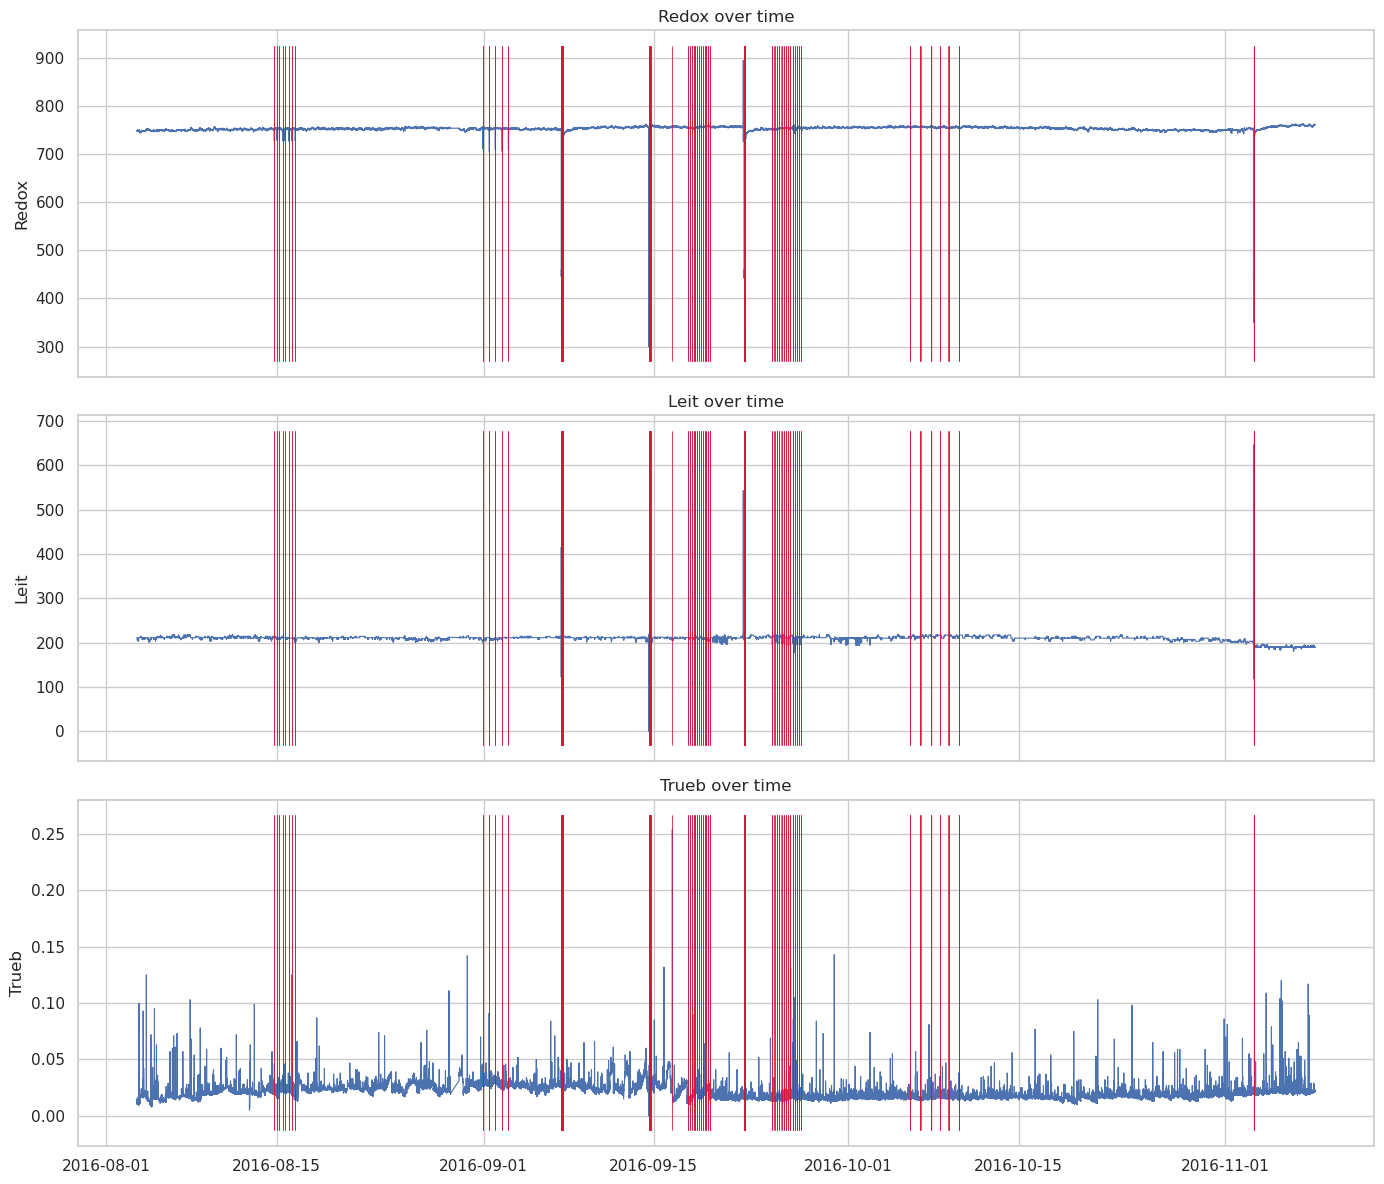

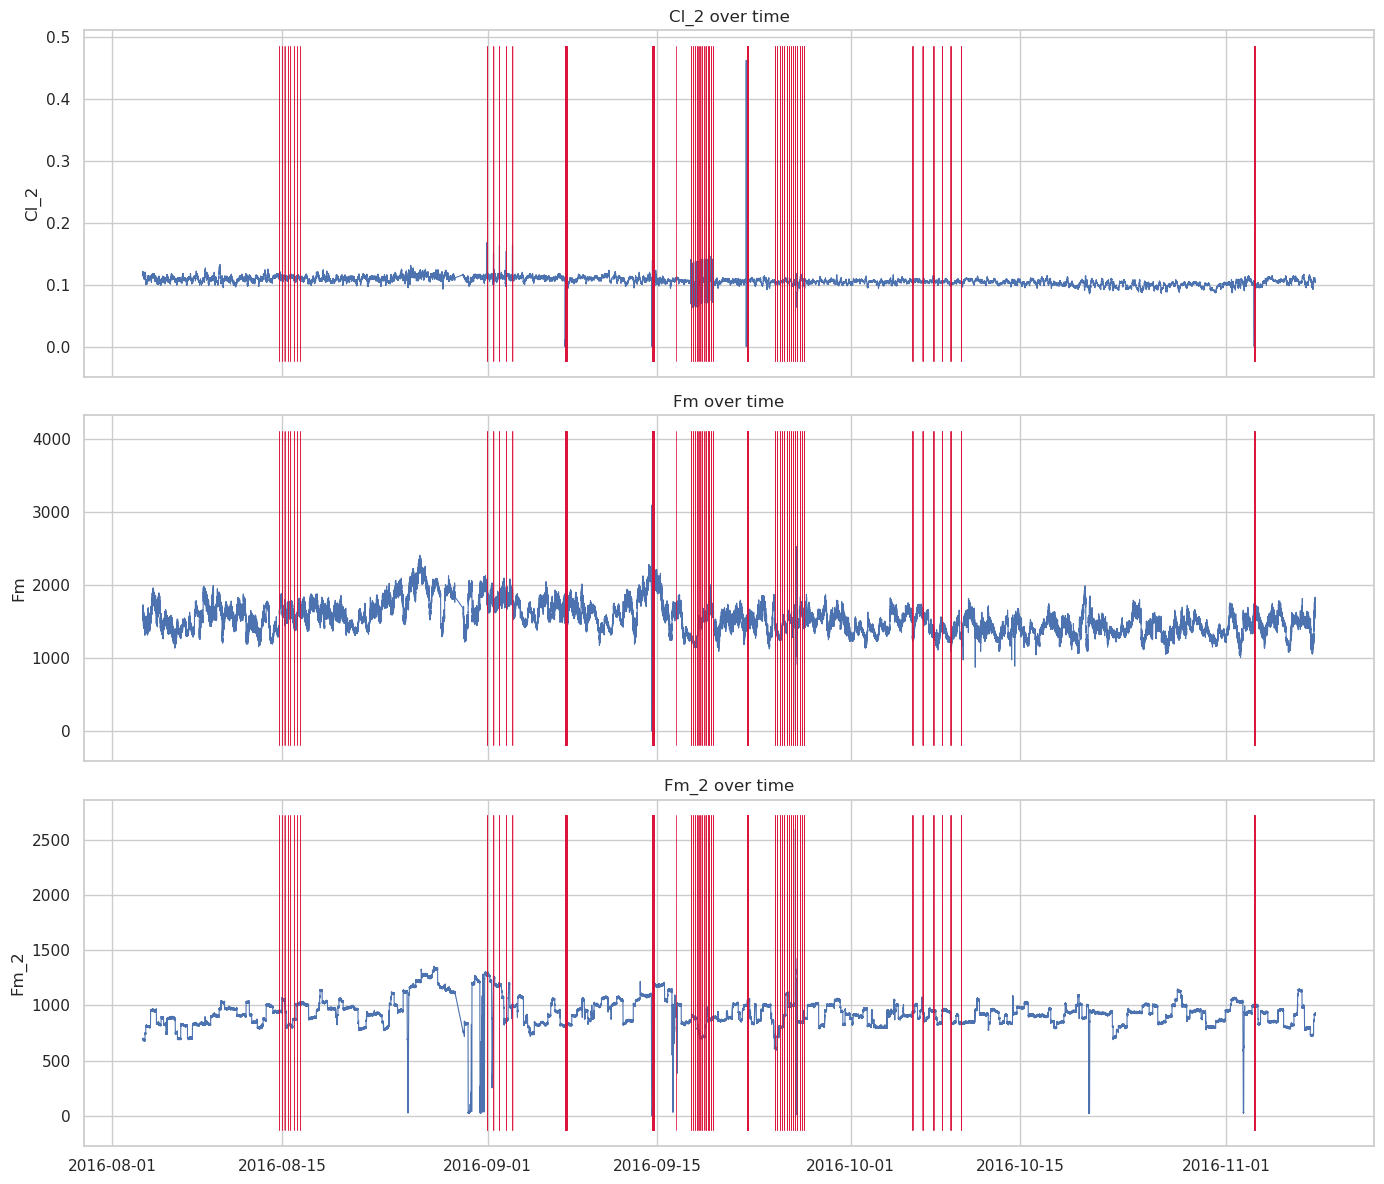

In [7]:
# Time series plots with event overlays
import matplotlib.pyplot as plt

def plot_timeseries_with_events(df_ts, columns, event_col="EVENT", max_cols_per_fig=3, save=False, prefix="ts"):
    cols = list(columns)
    for start in range(0, len(cols), max_cols_per_fig):
        subset = cols[start:start+max_cols_per_fig]
        n = len(subset)
        fig, axes = plt.subplots(n, 1, figsize=(14, 4*n), sharex=True)
        if n == 1:
            axes = [axes]
        for ax, col in zip(axes, subset):
            ax.plot(df_ts.index, df_ts[col], color="C0", linewidth=0.8)
            ax.set_ylabel(col)
            ax.set_title(f"{col} over time")
            if event_col in df_ts.columns:
                event_times = df_ts.index[df_ts[event_col]]
                if len(event_times) > 0:
                    ymin, ymax = ax.get_ylim()
                    ax.vlines(event_times, ymin=ymin, ymax=ymax, color="crimson", alpha=0.2, linewidth=0.5)
        plt.tight_layout()
        if save:
            from pathlib import Path as _Path
            out = _Path(FIGURES_DIR) / f"{prefix}_{start//max_cols_per_fig+1}.png"
            fig.savefig(out, dpi=150, bbox_inches="tight")
        plt.show()

sensor_cols = ["Tp", "Cl", "pH", "Redox", "Leit", "Trueb", "Cl_2", "Fm", "Fm_2"]
plot_timeseries_with_events(df_ts, sensor_cols, save=True, prefix="timeseries")

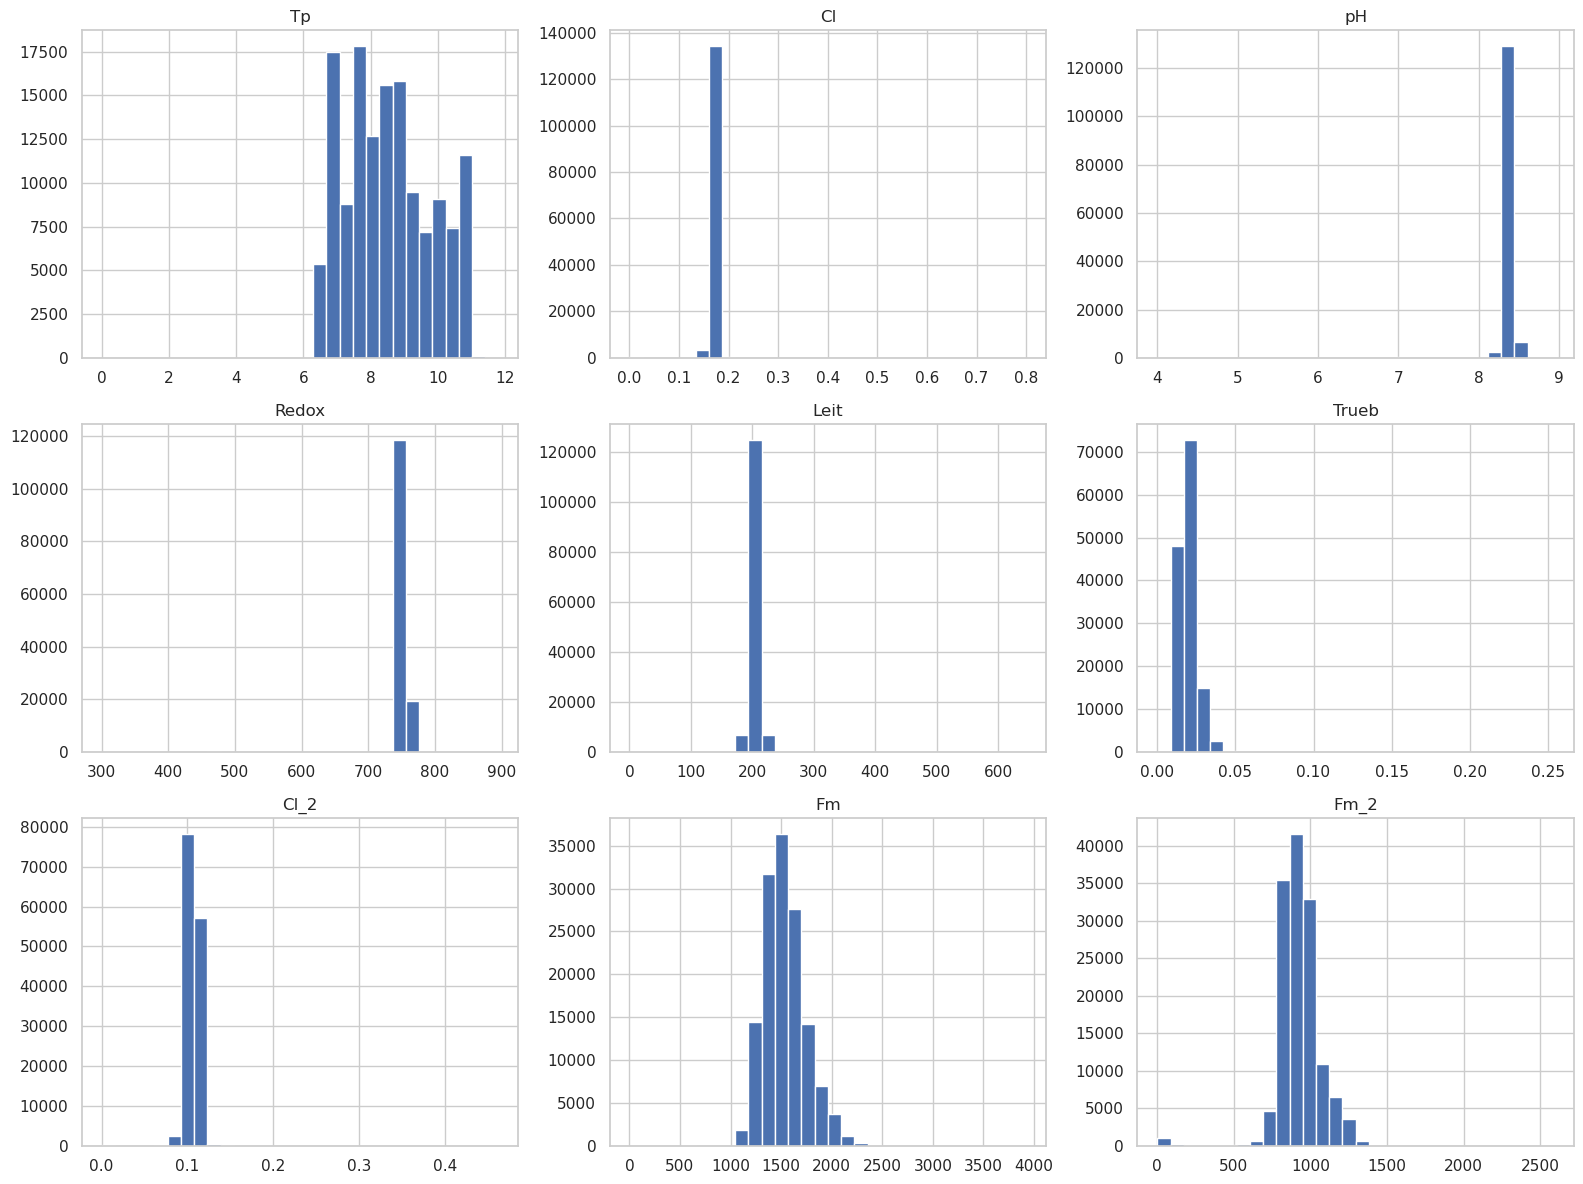

In [8]:
# Distributions
numeric_cols = df_ts.select_dtypes(include=[np.number]).columns.tolist()
df_ts[numeric_cols].hist(bins=30, figsize=(16, 12))
plt.tight_layout()
plt.show()

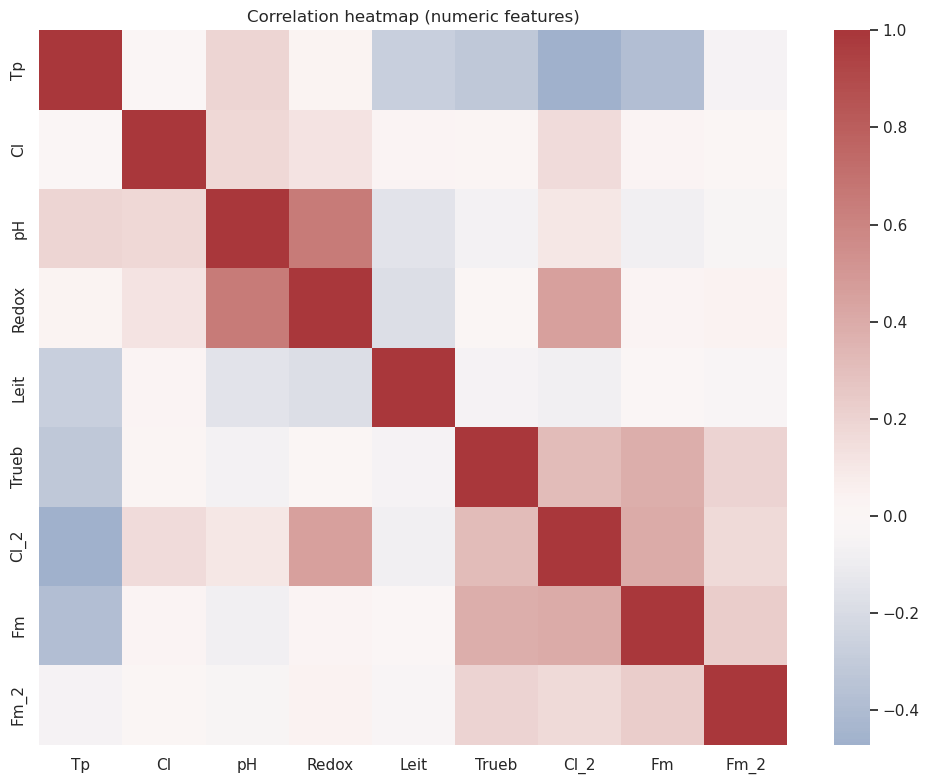

In [9]:
# Correlation heatmap
numeric_cols = df_ts.select_dtypes(include=[np.number]).columns.tolist()
corr = df_ts[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="vlag", center=0)
plt.title("Correlation heatmap (numeric features)")
plt.tight_layout()
plt.show()

/tmp/ipykernel_7729/4179819612.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_roll = df_ts[sensor_cols].resample(window).mean()


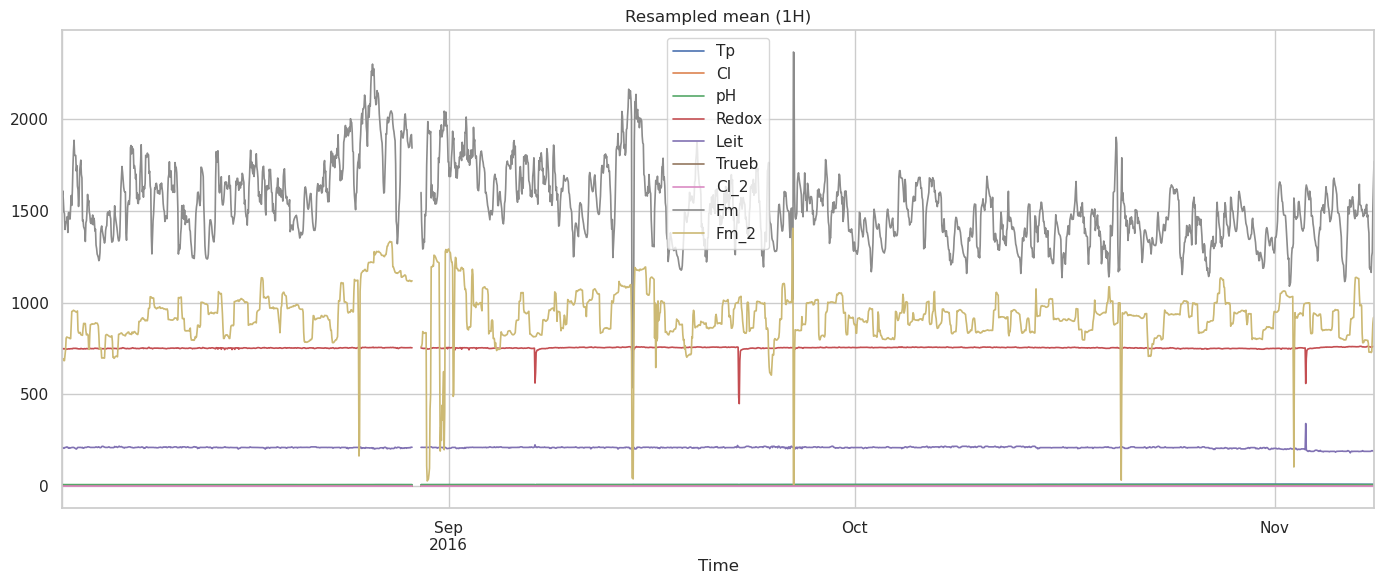

In [10]:
# Resampled means as a smoother view
sensor_cols = ["Tp", "Cl", "pH", "Redox", "Leit", "Trueb", "Cl_2", "Fm", "Fm_2"]
window = "1H"
df_roll = df_ts[sensor_cols].resample(window).mean()
_ = df_roll.plot(subplots=False, figsize=(14,6), linewidth=1.2)
plt.title(f"Resampled mean ({window})")
plt.tight_layout()
plt.show()

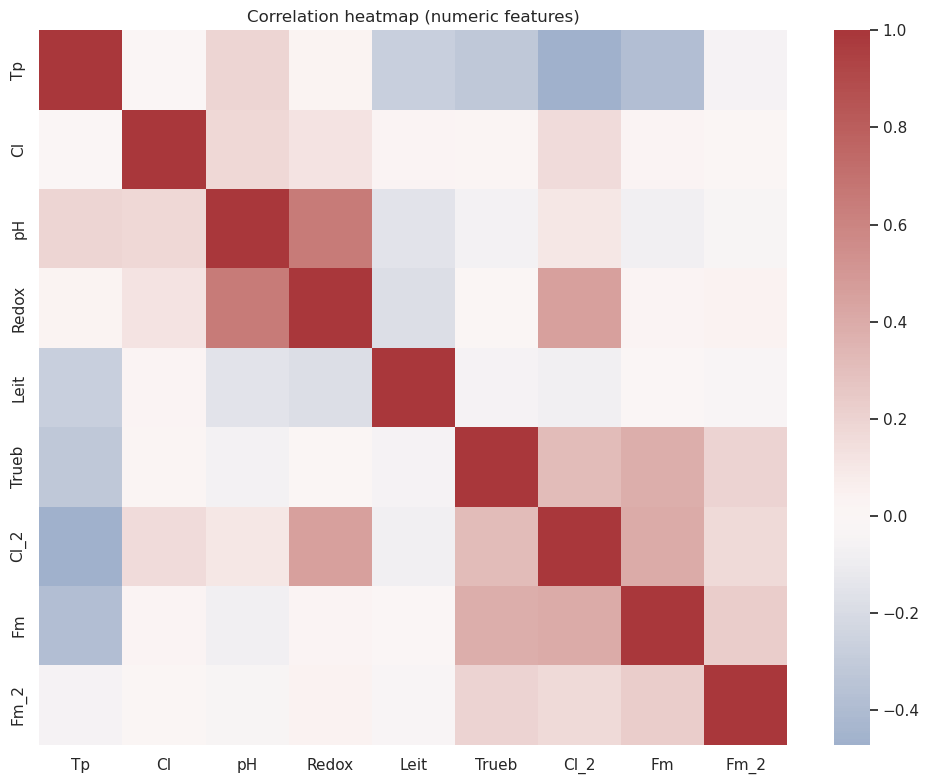

Saved: /home/nelso/Documents/IA - Detecção Falhas/reports/figures/correlation_heatmap.png


In [11]:
# Save correlation heatmap to figures
from pathlib import Path as _Path
numeric_cols = df_ts.select_dtypes(include=[np.number]).columns.tolist()
corr = df_ts[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="vlag", center=0)
plt.title("Correlation heatmap (numeric features)")
plt.tight_layout()
out = _Path(FIGURES_DIR) / "correlation_heatmap.png"
plt.savefig(out, dpi=150, bbox_inches="tight")
plt.show()
print("Saved:", out)

## Anomaly-Focused Visualizations

As per the Novel Dynamic Ensemble paper (Ribeiro et al., 2020), we now add **zoomed visualizations** that focus on anomaly regions. This dual perspective (overview + close-up) helps understand anomaly patterns in detail.

In [12]:
def get_anomaly_windows(df_ts, event_col='EVENT', margin_minutes=60):
    """
    Extract time windows around anomalies with margin.
    Returns list of tuples: (start_time, end_time, anomaly_start, anomaly_end)
    """
    import pandas as pd
    
    # Find contiguous anomaly regions
    events = df_ts[event_col].copy()
    # Identify transitions
    event_starts = events & ~events.shift(1, fill_value=False)
    event_ends = events & ~events.shift(-1, fill_value=False)
    
    start_times = df_ts.index[event_starts].tolist()
    end_times = df_ts.index[event_ends].tolist()
    
    if len(start_times) == 0:
        return []
    
    windows = []
    margin = pd.Timedelta(minutes=margin_minutes)
    
    for anom_start, anom_end in zip(start_times, end_times):
        # Add margin around anomaly
        win_start = max(df_ts.index.min(), anom_start - margin)
        win_end = min(df_ts.index.max(), anom_end + margin)
        windows.append((win_start, win_end, anom_start, anom_end))
    
    return windows

anomaly_windows = get_anomaly_windows(df_ts, margin_minutes=120)
print(f"Found {len(anomaly_windows)} anomaly regions")
if len(anomaly_windows) > 0:
    print(f"First anomaly window: {anomaly_windows[0][0]} to {anomaly_windows[0][1]}")

Found 51 anomaly regions
First anomaly window: 2016-08-14 16:54:00 to 2016-08-14 21:11:00


### Anomaly Statistics

Let's analyze the temporal characteristics of anomalies in the dataset.

ANOMALY TEMPORAL CHARACTERISTICS
Total anomaly regions: 51
Mean duration: 32.8 minutes
Median duration: 21.0 minutes
Min duration: 9.0 minutes
Max duration: 252.0 minutes
Std duration: 44.5 minutes


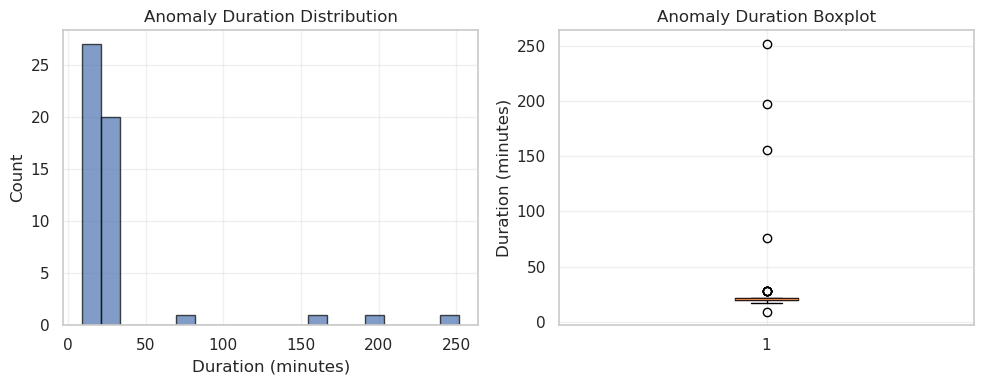

In [13]:
import pandas as pd

# Anomaly duration analysis
if len(anomaly_windows) > 0:
    durations = [(end - start).total_seconds() / 60 for _, _, start, end in anomaly_windows]
    
    print("=" * 60)
    print("ANOMALY TEMPORAL CHARACTERISTICS")
    print("=" * 60)
    print(f"Total anomaly regions: {len(anomaly_windows)}")
    print(f"Mean duration: {pd.Series(durations).mean():.1f} minutes")
    print(f"Median duration: {pd.Series(durations).median():.1f} minutes")
    print(f"Min duration: {pd.Series(durations).min():.1f} minutes")
    print(f"Max duration: {pd.Series(durations).max():.1f} minutes")
    print(f"Std duration: {pd.Series(durations).std():.1f} minutes")
    print("=" * 60)
    
    # Duration distribution
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(durations, bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Duration (minutes)')
    plt.ylabel('Count')
    plt.title('Anomaly Duration Distribution')
    plt.grid(alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.boxplot(durations, vert=True)
    plt.ylabel('Duration (minutes)')
    plt.title('Anomaly Duration Boxplot')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No anomalies found in dataset.")

### Zoomed Time Series Views

Following the approach in Figure 1 of Ribeiro et al. (2020), we create **side-by-side views**: a broad overview (left) and zoomed close-ups on anomaly regions (right).

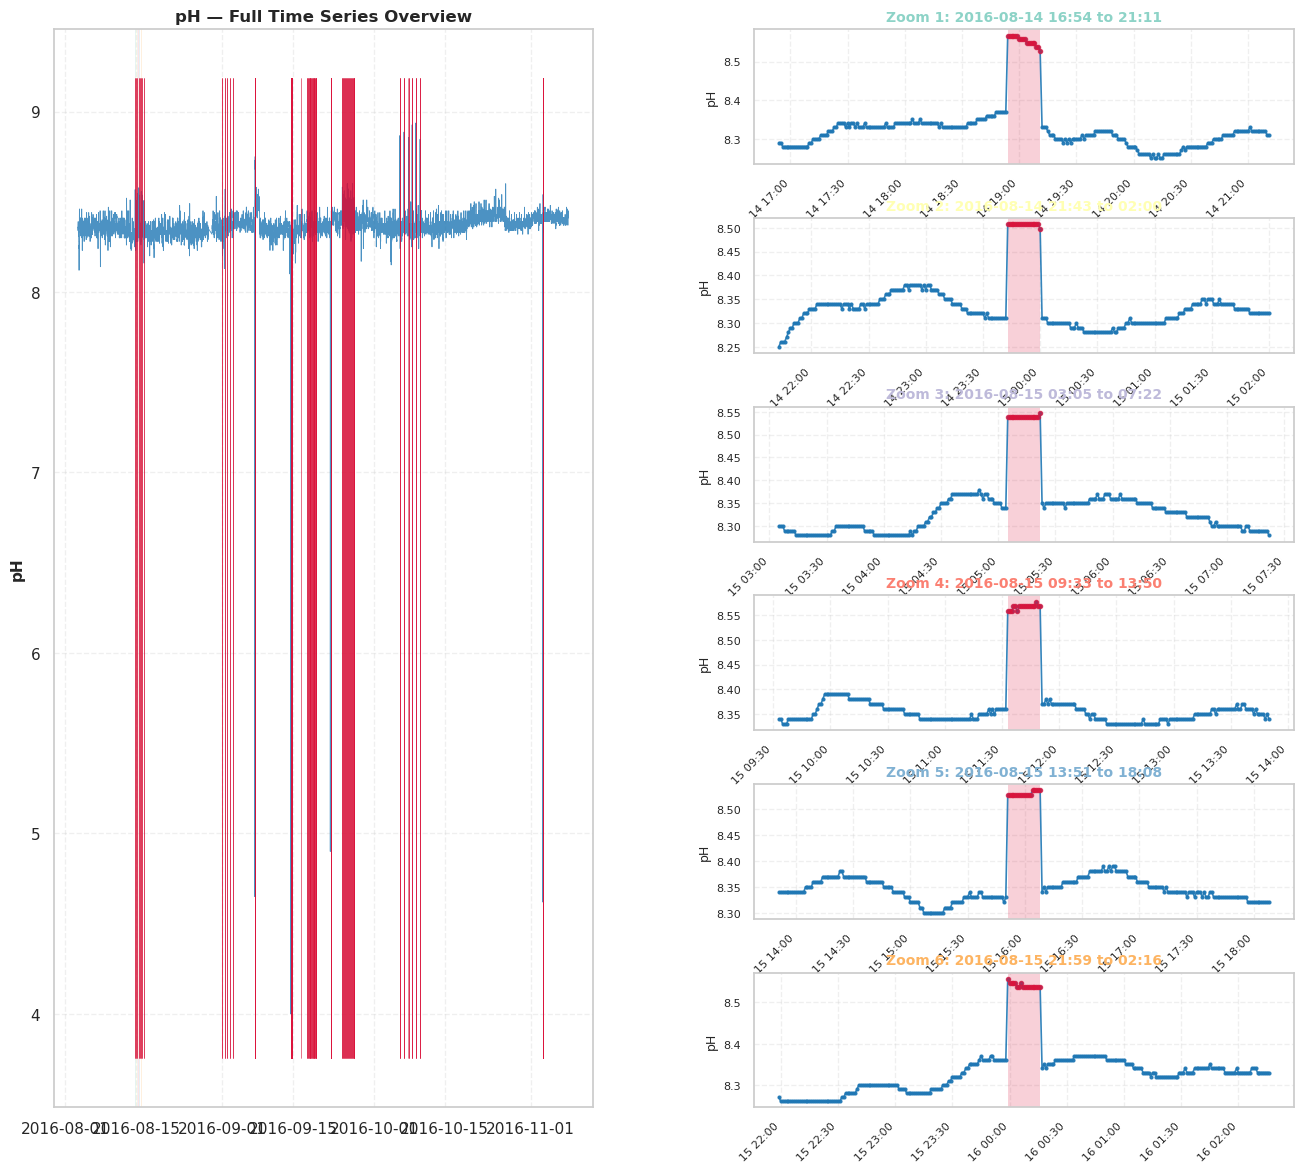

In [14]:
def plot_overview_and_zooms(df_ts, sensor_col, anomaly_windows, max_zooms=6, save=False):
    """
    Create a figure with overview on left and zoomed anomaly regions on right.
    Replicates the visualization style from Ribeiro et al. (2020) Figure 1.
    """
    from pathlib import Path as _Path
    import matplotlib.patches as mpatches
    
    # Limit number of zoom windows to display
    display_windows = anomaly_windows[:max_zooms]
    n_zooms = len(display_windows)
    
    if n_zooms == 0:
        print(f"No anomalies to zoom for {sensor_col}")
        return
    
    # Create figure with 2 columns: overview + zooms
    fig = plt.figure(figsize=(16, 2 + 2*n_zooms))
    gs = fig.add_gridspec(n_zooms, 2, hspace=0.4, wspace=0.3)
    
    # Left column: Full overview (spans all rows)
    ax_overview = fig.add_subplot(gs[:, 0])
    
    # Plot full time series
    ax_overview.plot(df_ts.index, df_ts[sensor_col], color='#1f77b4', linewidth=0.6, alpha=0.8)
    ax_overview.set_ylabel(f'{sensor_col}', fontsize=11, fontweight='bold')
    ax_overview.set_title(f'{sensor_col} — Full Time Series Overview', fontsize=12, fontweight='bold')
    ax_overview.grid(alpha=0.3, linestyle='--')
    
    # Highlight anomaly regions on overview
    event_mask = df_ts['EVENT']
    if event_mask.any():
        ymin, ymax = ax_overview.get_ylim()
        event_times = df_ts.index[event_mask]
        ax_overview.vlines(event_times, ymin, ymax, colors='crimson', alpha=0.15, linewidth=0.4)
    
    # Mark zoom regions with colored boxes
    colors_zoom = plt.cm.Set3(range(n_zooms))
    for i, (win_start, win_end, _, _) in enumerate(display_windows):
        ax_overview.axvspan(win_start, win_end, alpha=0.2, color=colors_zoom[i], linewidth=0)
    
    # Right column: Zoomed views
    for i, (win_start, win_end, anom_start, anom_end) in enumerate(display_windows):
        ax_zoom = fig.add_subplot(gs[i, 1])
        
        # Extract window data
        mask = (df_ts.index >= win_start) & (df_ts.index <= win_end)
        df_window = df_ts.loc[mask]
        
        if len(df_window) == 0:
            continue
        
        # Plot zoomed region
        ax_zoom.plot(df_window.index, df_window[sensor_col], 
                    color='#1f77b4', linewidth=1.2, marker='o', markersize=2, alpha=0.9)
        
        # Highlight anomaly region within zoom
        anom_mask = df_window['EVENT']
        if anom_mask.any():
            ax_zoom.plot(df_window.index[anom_mask], df_window.loc[anom_mask, sensor_col],
                        color='crimson', linewidth=0, marker='o', markersize=3, alpha=0.7, label='Anomaly')
            # Shade anomaly period
            ymin_z, ymax_z = ax_zoom.get_ylim()
            ax_zoom.axvspan(anom_start, anom_end, alpha=0.2, color='crimson', linewidth=0)
        
        ax_zoom.set_ylabel(f'{sensor_col}', fontsize=9)
        ax_zoom.set_title(f'Zoom {i+1}: {win_start.strftime("%Y-%m-%d %H:%M")} to {win_end.strftime("%H:%M")}', 
                         fontsize=10, color=colors_zoom[i], fontweight='bold')
        ax_zoom.grid(alpha=0.3, linestyle='--')
        ax_zoom.tick_params(labelsize=8)
        
        # Rotate x-axis labels
        for label in ax_zoom.get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
    
    if save:
        out = _Path(FIGURES_DIR) / f"zoomed_anomaly_{sensor_col.lower()}.png"
        fig.savefig(out, dpi=150, bbox_inches='tight')
        print(f"Saved: {out}")
    
    plt.show()

# Test with one sensor
if len(anomaly_windows) > 0:
    plot_overview_and_zooms(df_ts, 'pH', anomaly_windows, max_zooms=6, save=False)
else:
    print("No anomalies to visualize.")

### Zoomed Views for All Sensors

Generate overview + zoom visualizations for each sensor variable.


Processing: Tp
Saved: /home/nelso/Documents/IA - Detecção Falhas/reports/figures/zoomed_anomaly_tp.png


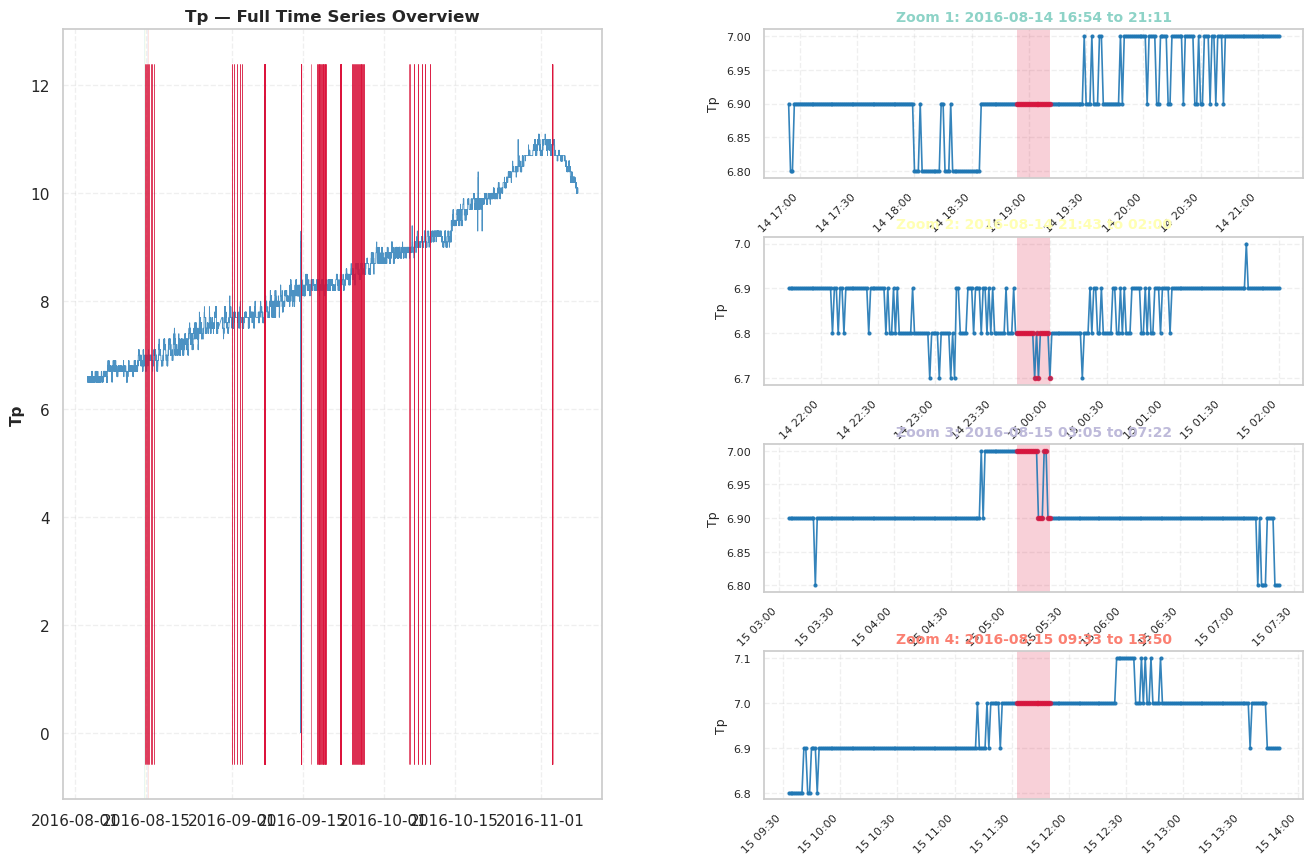


Processing: Cl
Saved: /home/nelso/Documents/IA - Detecção Falhas/reports/figures/zoomed_anomaly_cl.png


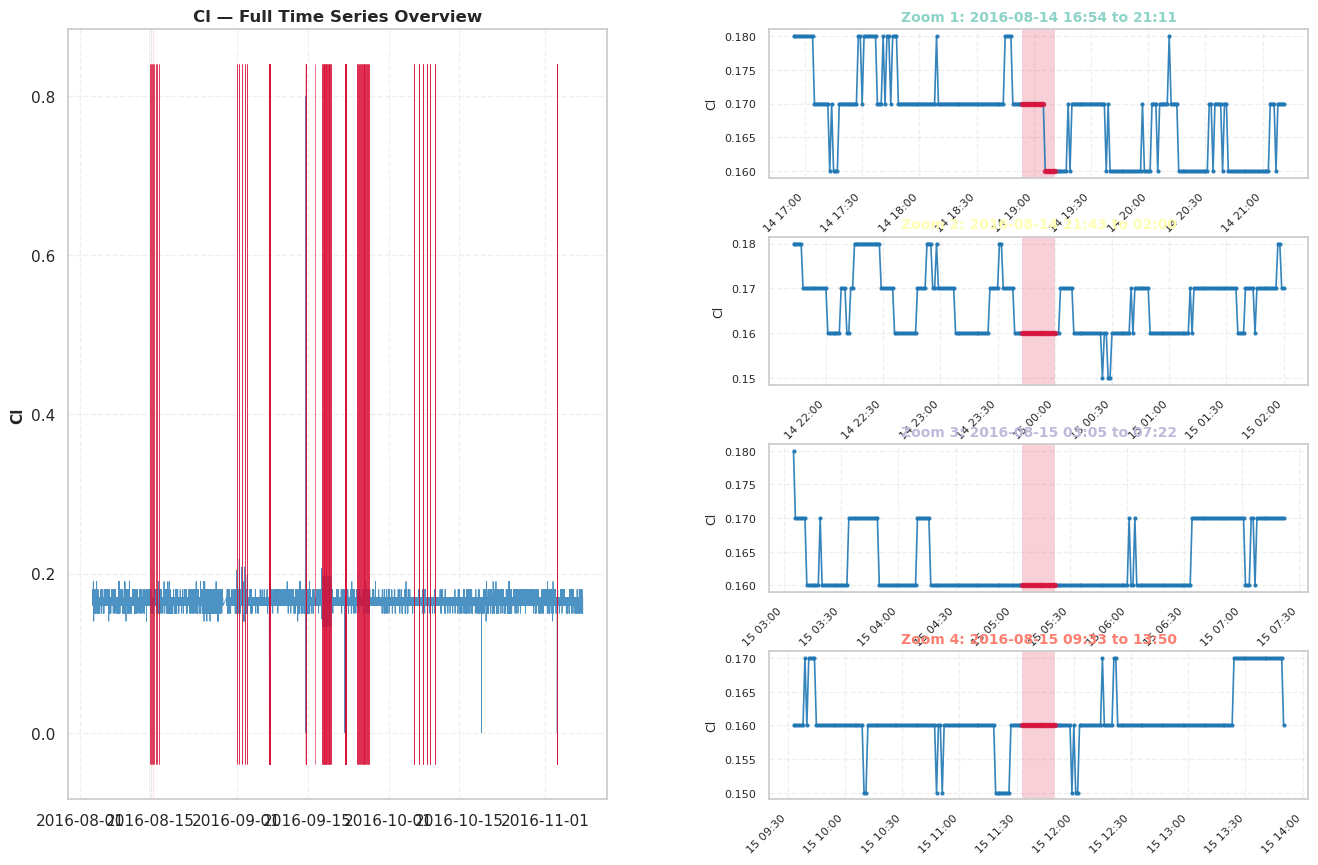


Processing: pH
Saved: /home/nelso/Documents/IA - Detecção Falhas/reports/figures/zoomed_anomaly_ph.png


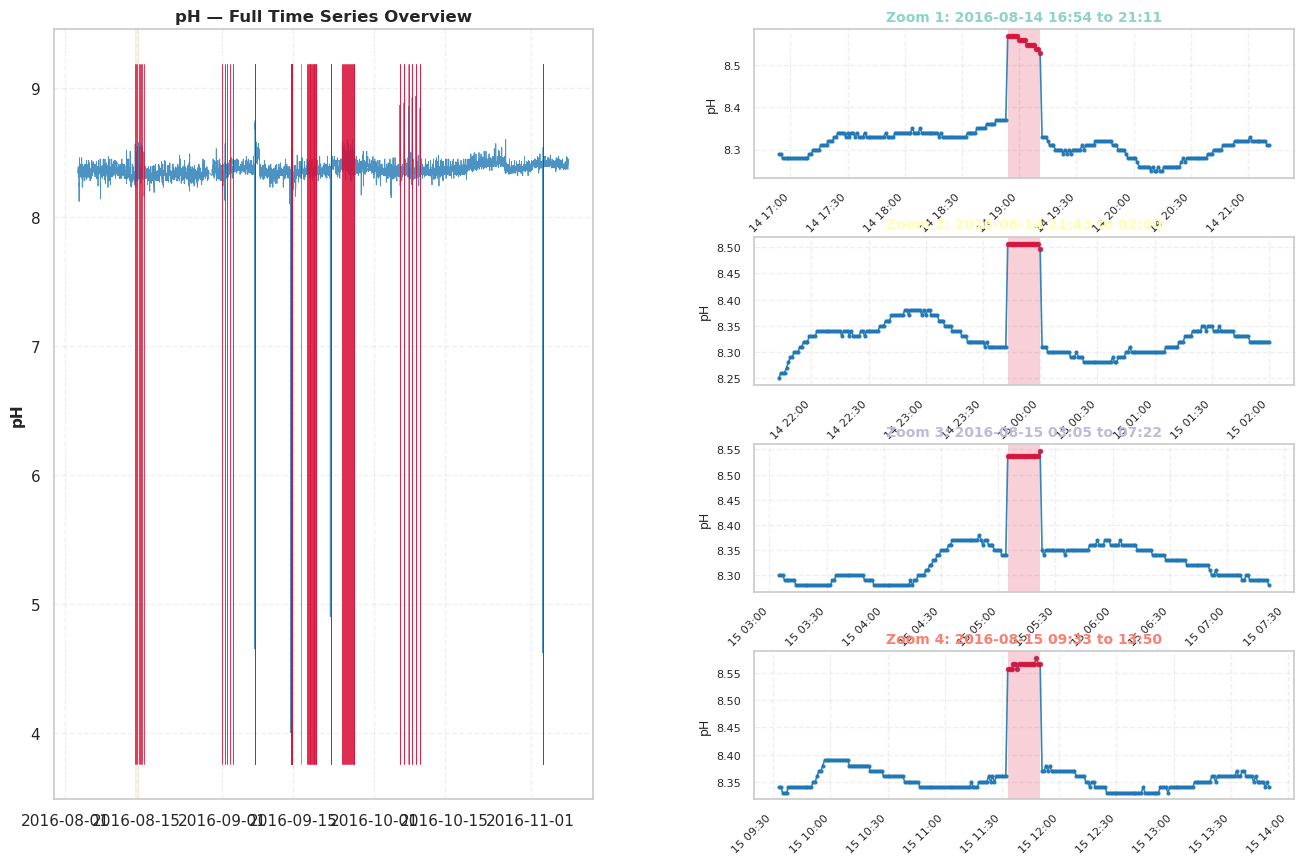


Processing: Redox
Saved: /home/nelso/Documents/IA - Detecção Falhas/reports/figures/zoomed_anomaly_redox.png


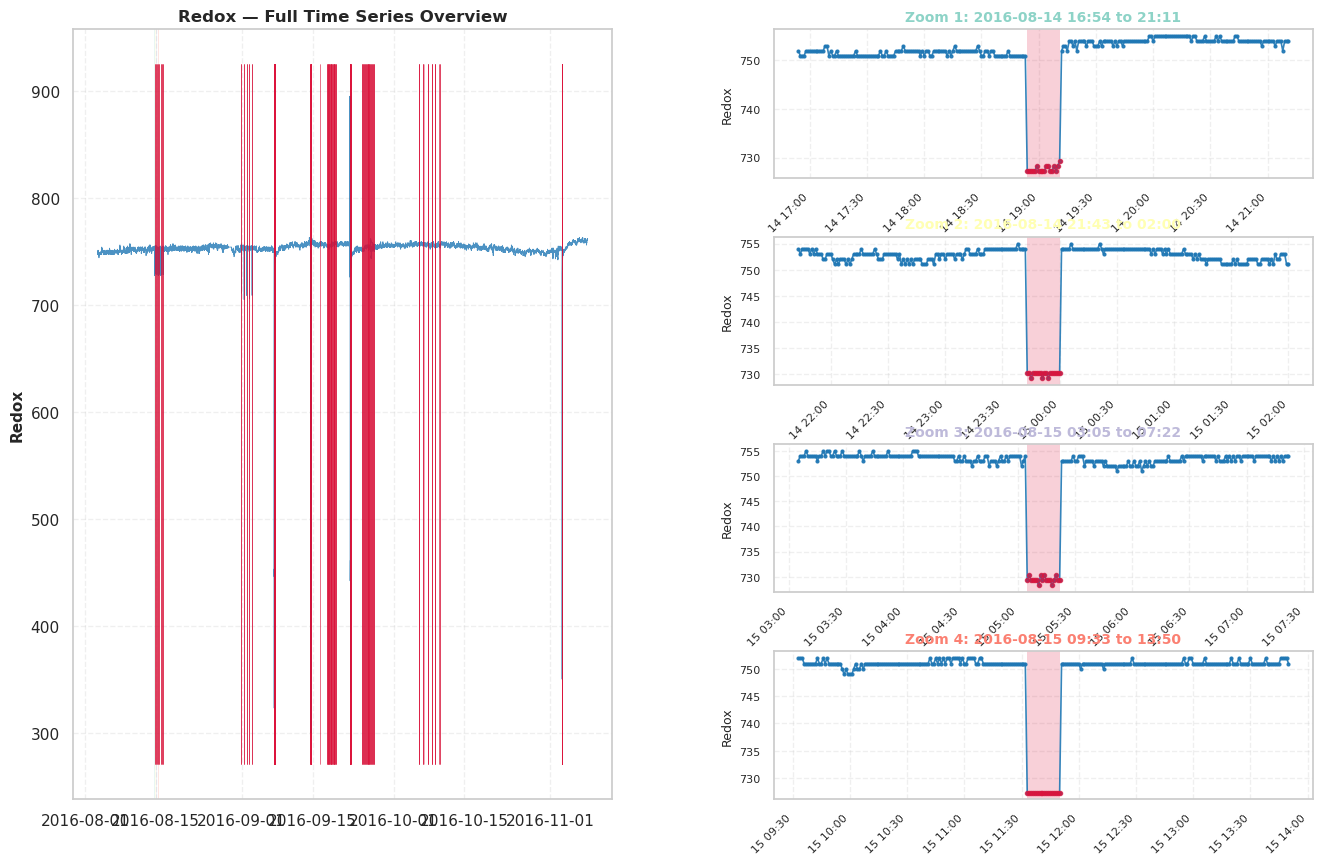


Processing: Leit
Saved: /home/nelso/Documents/IA - Detecção Falhas/reports/figures/zoomed_anomaly_leit.png


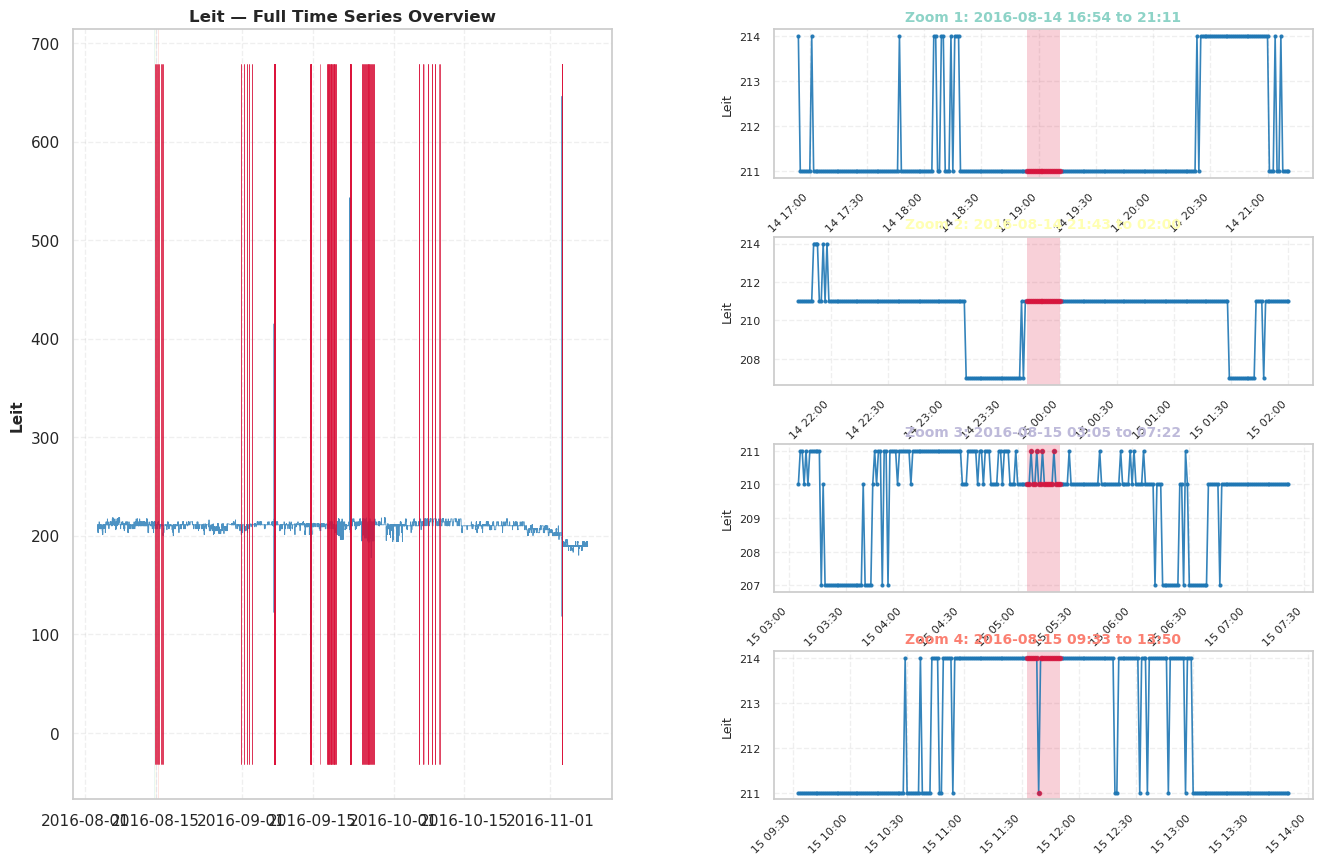


Processing: Trueb
Saved: /home/nelso/Documents/IA - Detecção Falhas/reports/figures/zoomed_anomaly_trueb.png


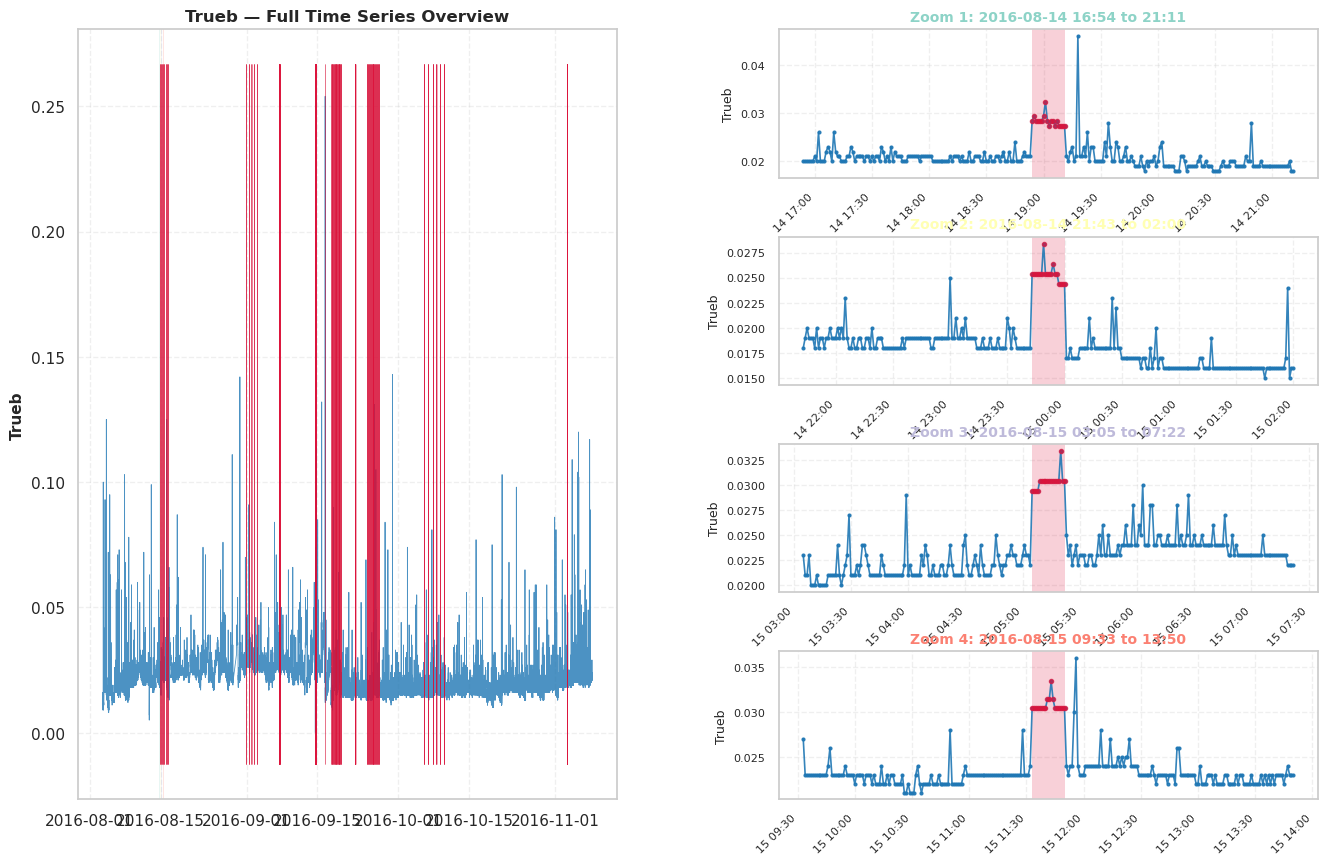


Processing: Cl_2
Saved: /home/nelso/Documents/IA - Detecção Falhas/reports/figures/zoomed_anomaly_cl_2.png


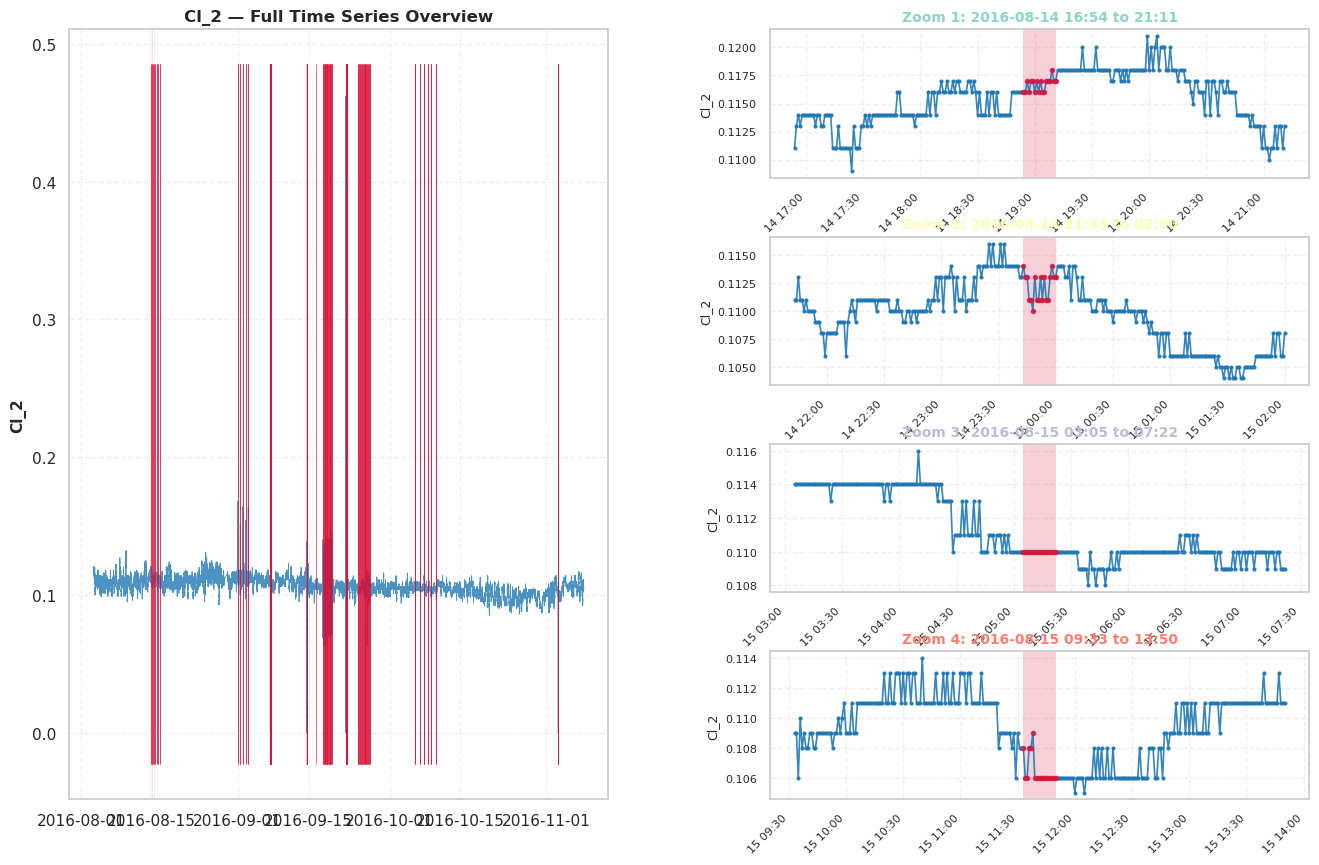


Processing: Fm
Saved: /home/nelso/Documents/IA - Detecção Falhas/reports/figures/zoomed_anomaly_fm.png


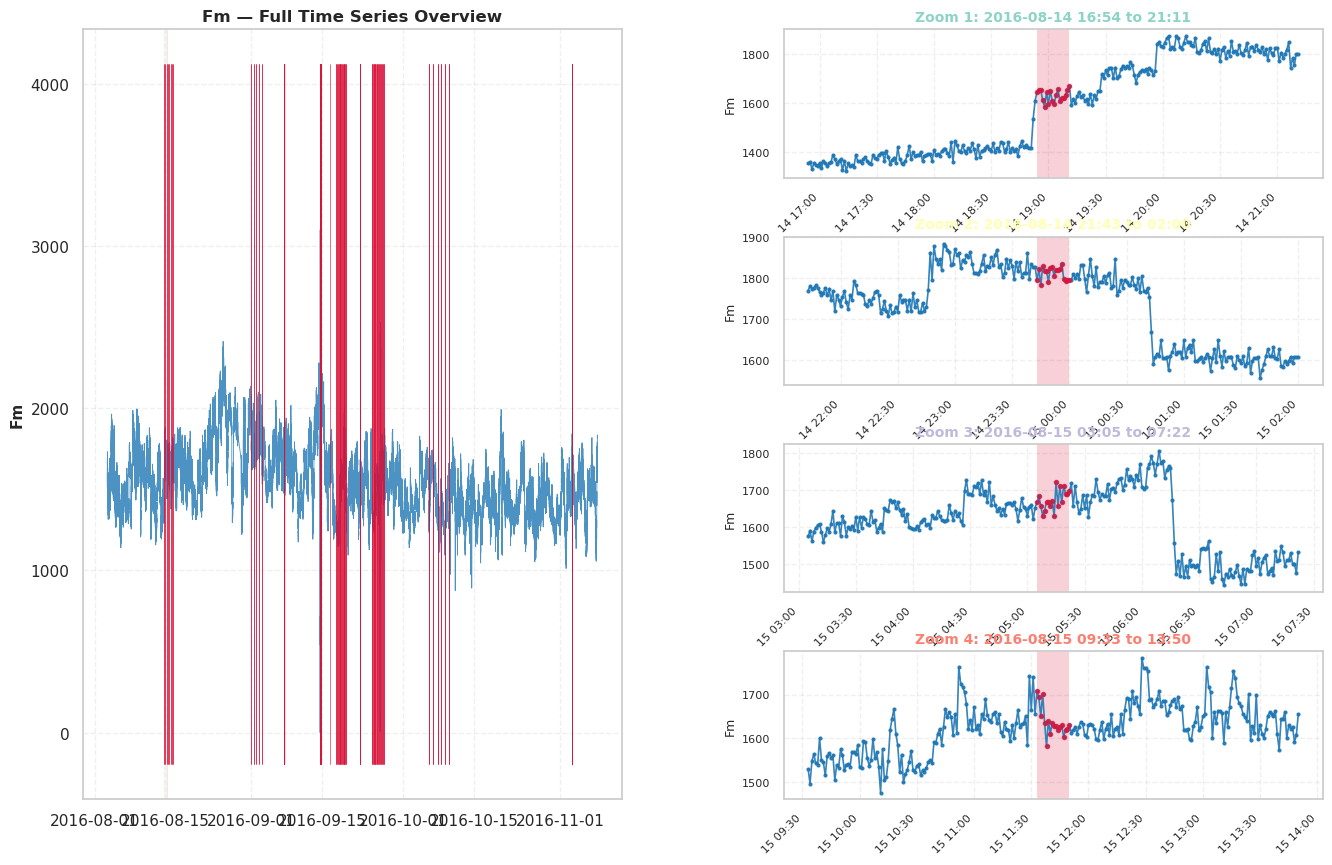


Processing: Fm_2
Saved: /home/nelso/Documents/IA - Detecção Falhas/reports/figures/zoomed_anomaly_fm_2.png


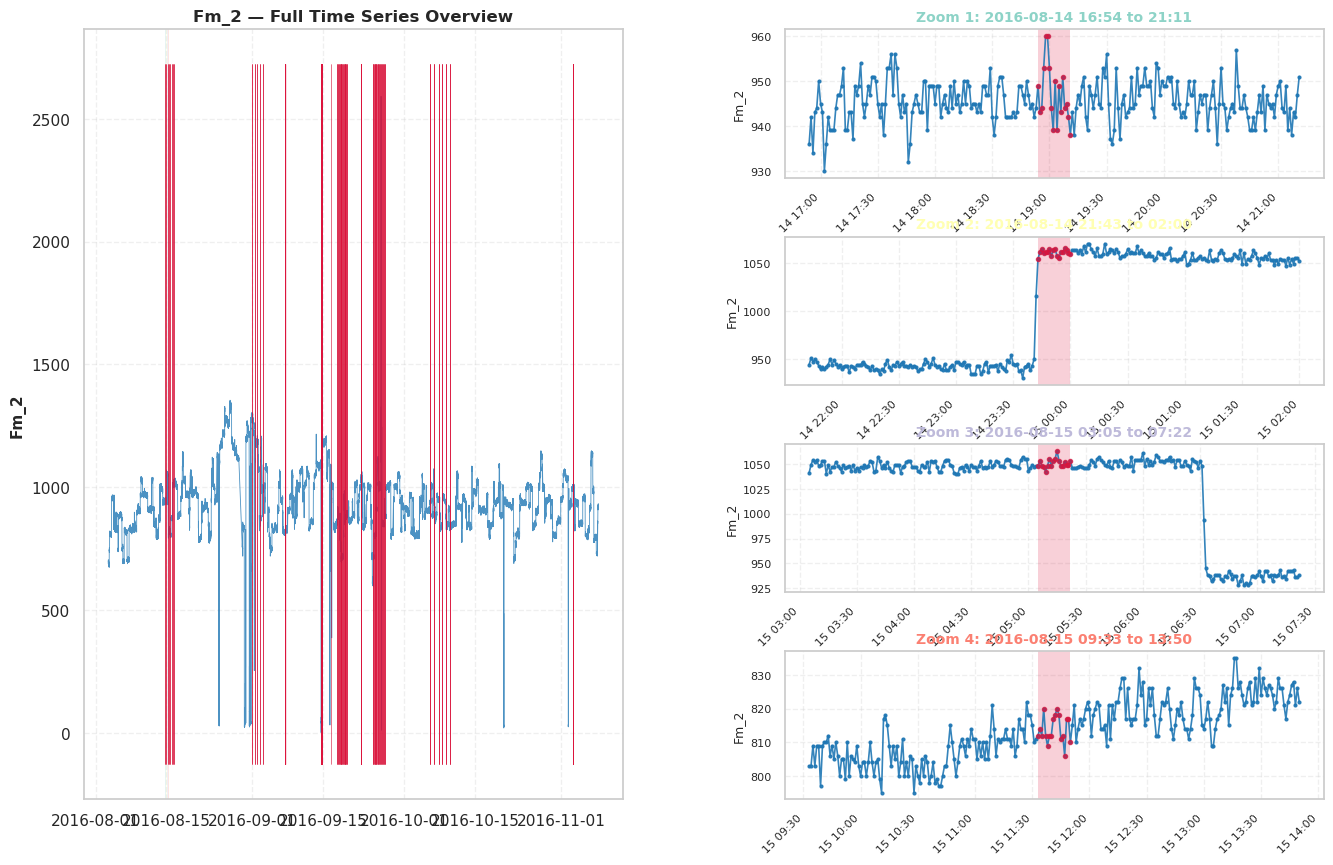

In [15]:
# Generate zoomed visualizations for all sensors
sensor_cols = ['Tp', 'Cl', 'pH', 'Redox', 'Leit', 'Trueb', 'Cl_2', 'Fm', 'Fm_2']

if len(anomaly_windows) > 0:
    for sensor in sensor_cols:
        print(f"\n{'='*60}")
        print(f"Processing: {sensor}")
        print('='*60)
        plot_overview_and_zooms(df_ts, sensor, anomaly_windows, max_zooms=4, save=True)
else:
    print("No anomalies found in dataset to visualize.")

### Multi-Sensor Anomaly Comparison

Compare how different sensors respond during the same anomaly event.

Saved: /home/nelso/Documents/IA - Detecção Falhas/reports/figures/multisensor_anomaly_window_1.png


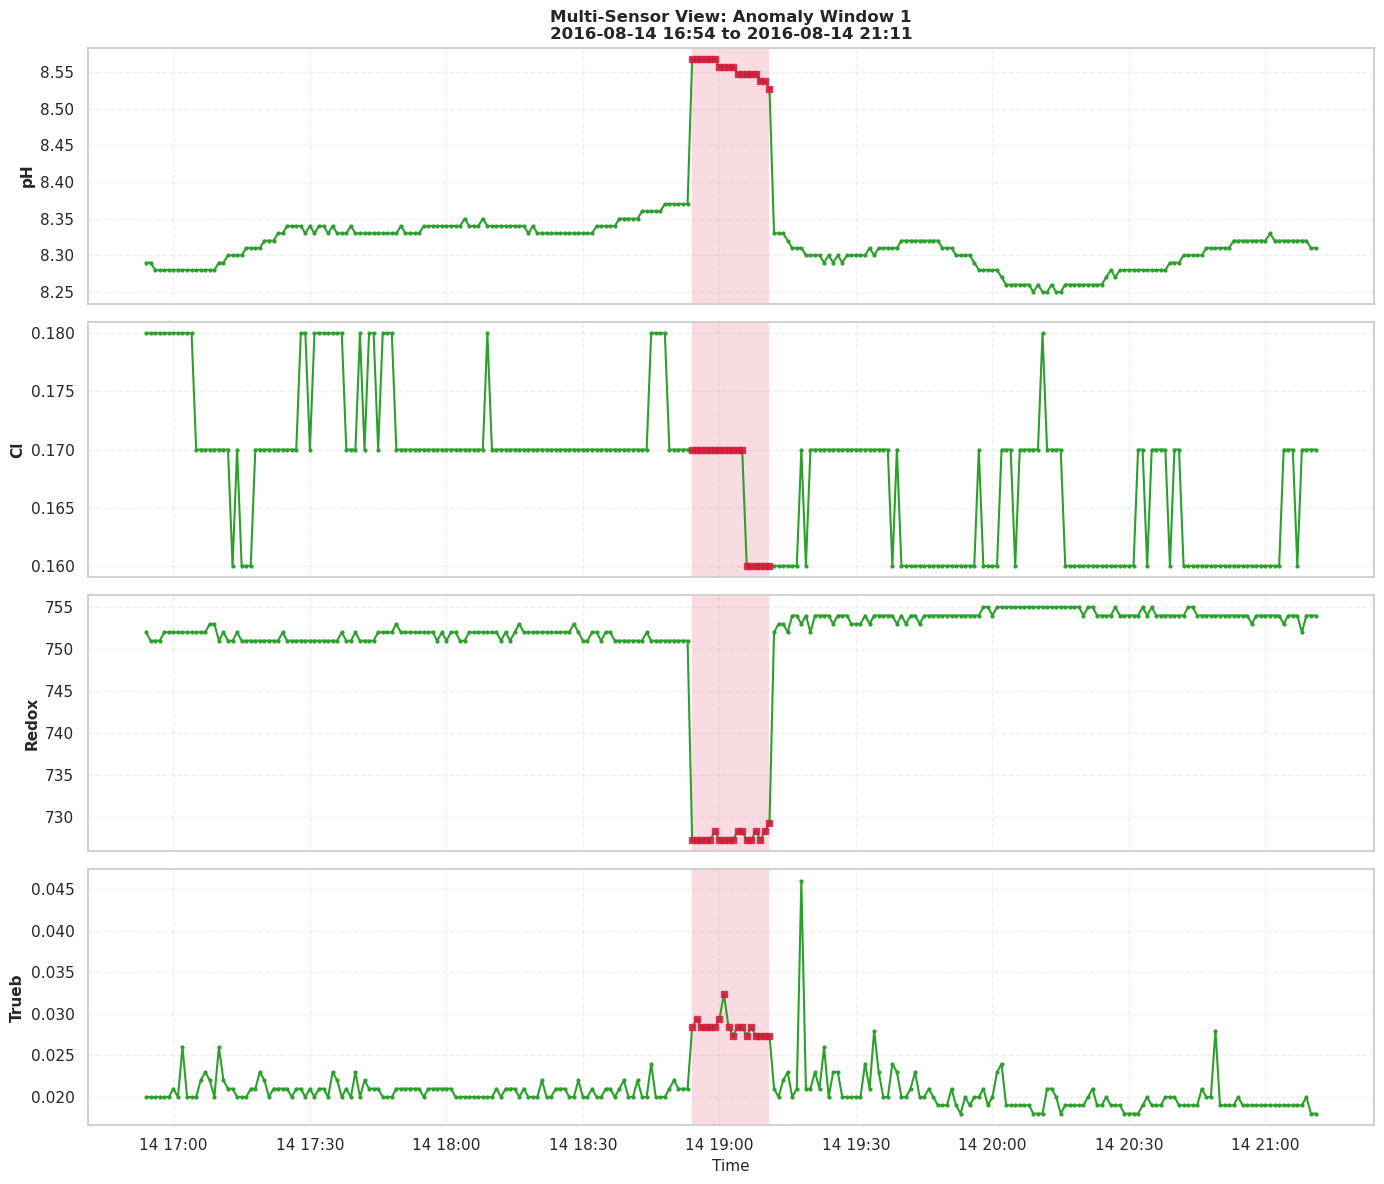

Saved: /home/nelso/Documents/IA - Detecção Falhas/reports/figures/multisensor_anomaly_window_2.png


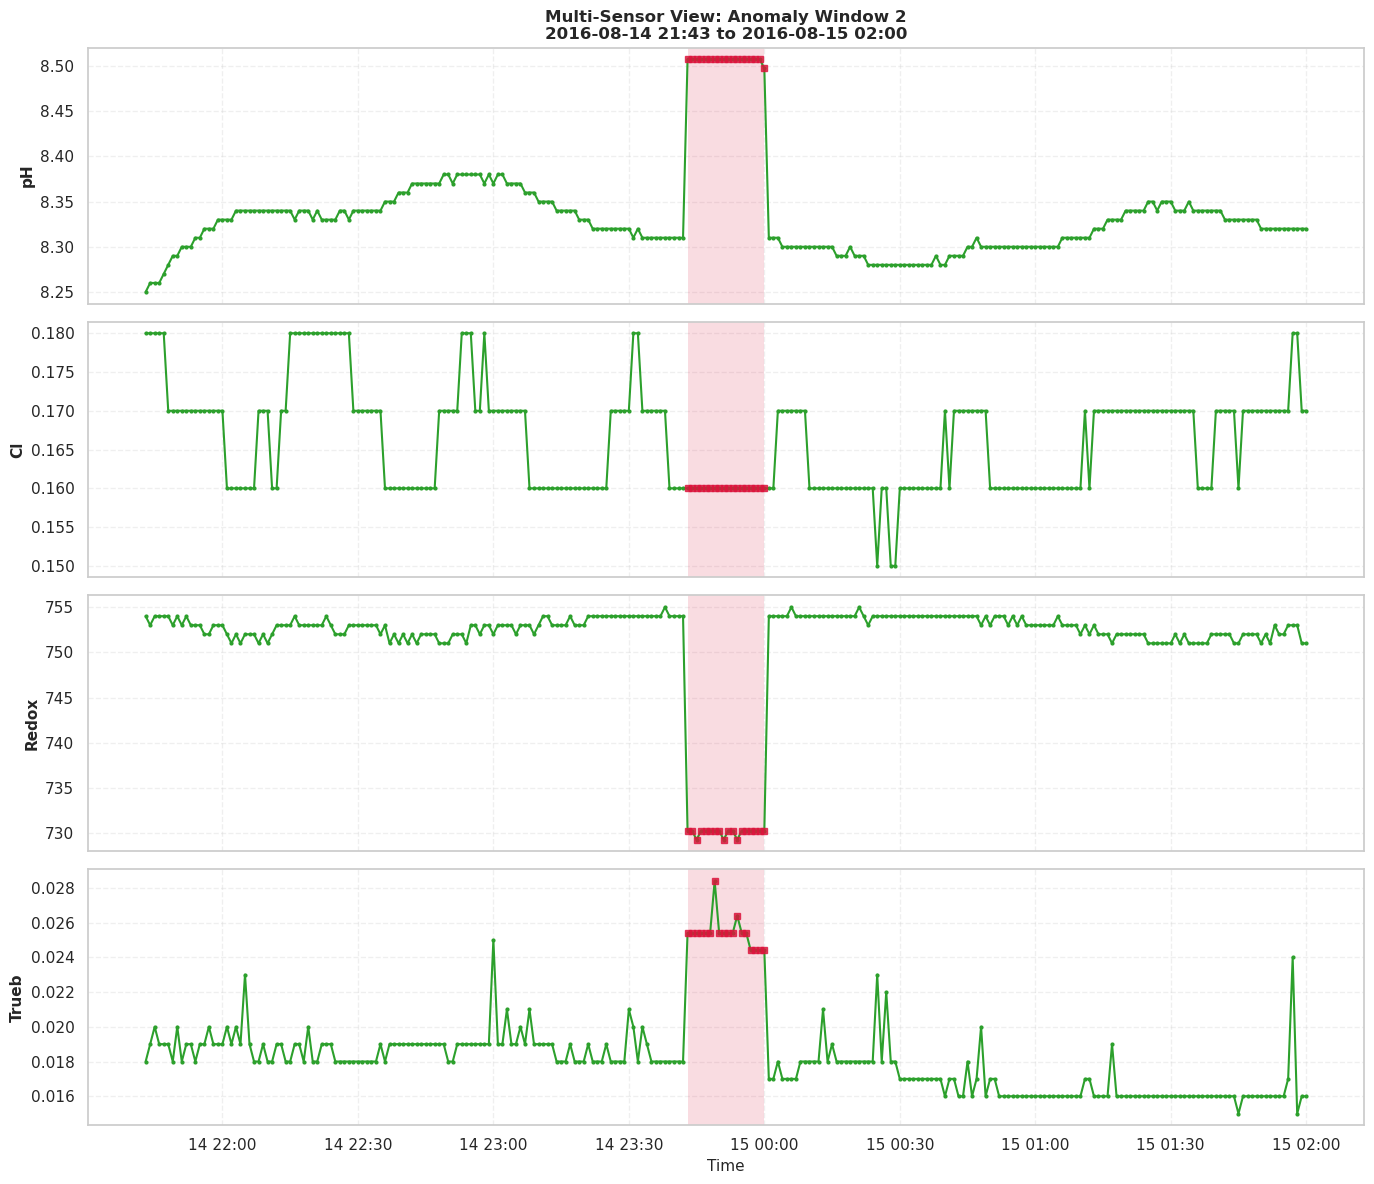

Saved: /home/nelso/Documents/IA - Detecção Falhas/reports/figures/multisensor_anomaly_window_3.png


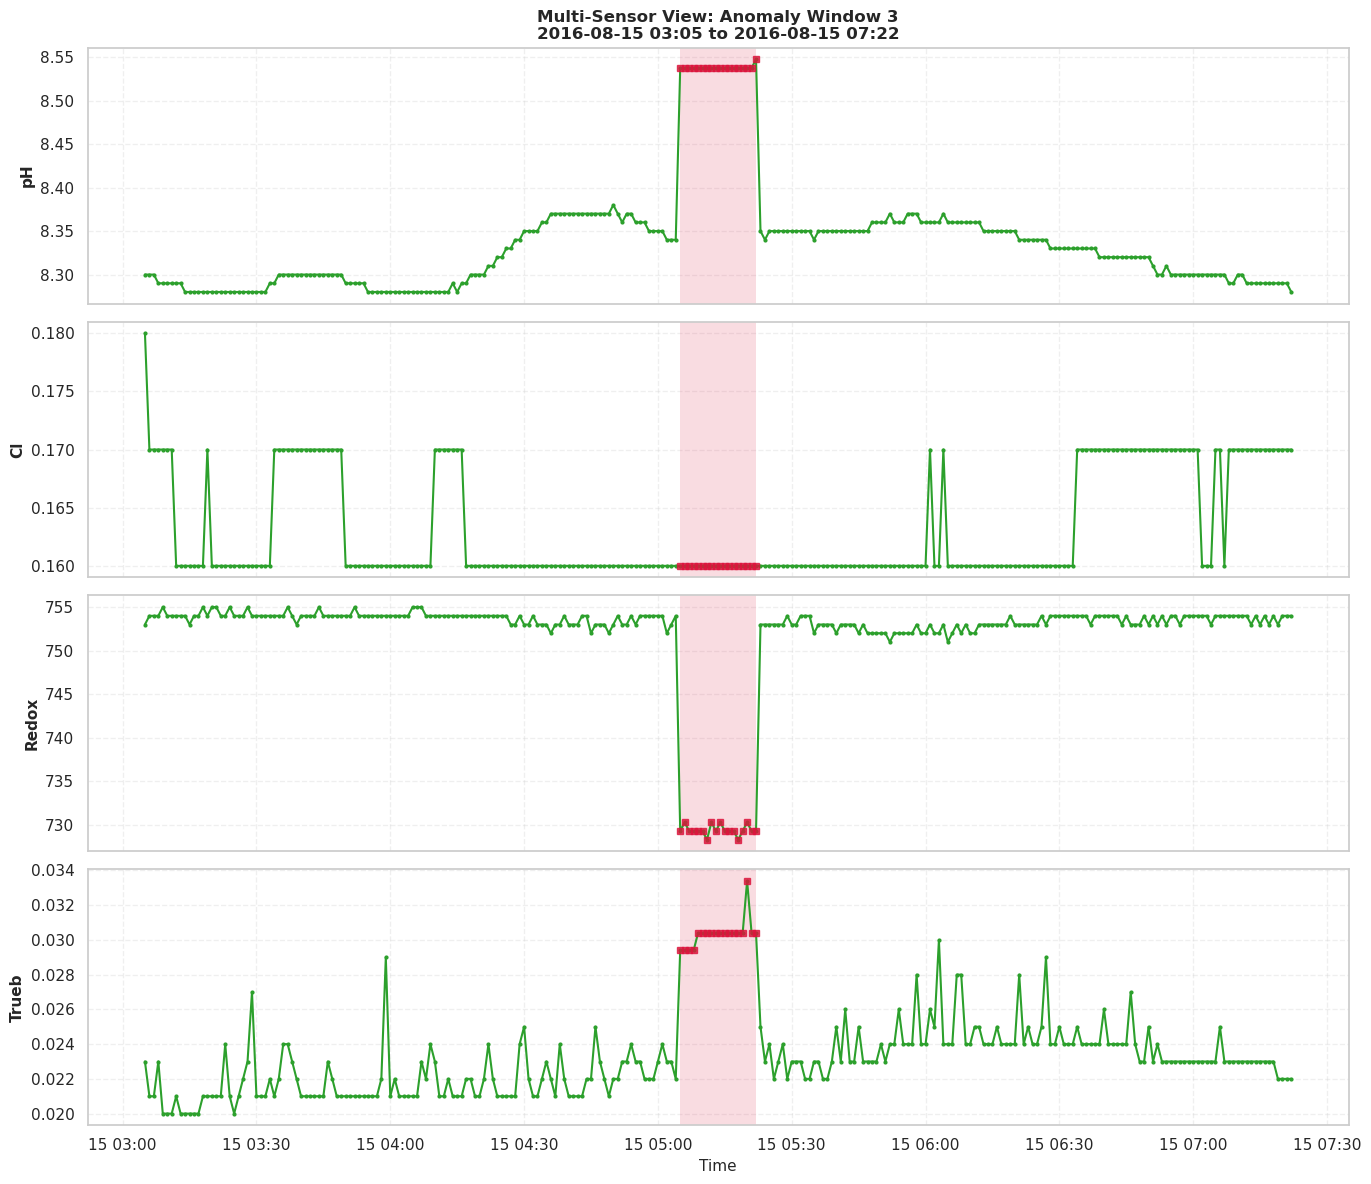

In [16]:
def plot_multisensor_anomaly_zoom(df_ts, anomaly_window_idx, sensors_to_plot, save=False):
    """
    Plot multiple sensors for a single anomaly window to compare responses.
    """
    from pathlib import Path as _Path
    
    if anomaly_window_idx >= len(anomaly_windows):
        print(f"Anomaly window {anomaly_window_idx} does not exist.")
        return
    
    win_start, win_end, anom_start, anom_end = anomaly_windows[anomaly_window_idx]
    
    # Extract window data
    mask = (df_ts.index >= win_start) & (df_ts.index <= win_end)
    df_window = df_ts.loc[mask]
    
    n_sensors = len(sensors_to_plot)
    fig, axes = plt.subplots(n_sensors, 1, figsize=(14, 3*n_sensors), sharex=True)
    if n_sensors == 1:
        axes = [axes]
    
    for ax, sensor in zip(axes, sensors_to_plot):
        # Plot sensor
        ax.plot(df_window.index, df_window[sensor], color='#2ca02c', linewidth=1.5, marker='o', markersize=2)
        
        # Highlight anomaly region
        anom_mask = df_window['EVENT']
        if anom_mask.any():
            ax.plot(df_window.index[anom_mask], df_window.loc[anom_mask, sensor],
                   color='crimson', linewidth=0, marker='s', markersize=4, alpha=0.8)
            ymin, ymax = ax.get_ylim()
            ax.axvspan(anom_start, anom_end, alpha=0.15, color='crimson', linewidth=0)
        
        ax.set_ylabel(sensor, fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3, linestyle='--')
    
    axes[0].set_title(f'Multi-Sensor View: Anomaly Window {anomaly_window_idx+1}\n'
                     f'{win_start.strftime("%Y-%m-%d %H:%M")} to {win_end.strftime("%Y-%m-%d %H:%M")}',
                     fontsize=12, fontweight='bold')
    axes[-1].set_xlabel('Time', fontsize=11)
    
    plt.tight_layout()
    
    if save:
        out = _Path(FIGURES_DIR) / f"multisensor_anomaly_window_{anomaly_window_idx+1}.png"
        fig.savefig(out, dpi=150, bbox_inches='tight')
        print(f"Saved: {out}")
    
    plt.show()

# Plot first few anomaly windows with multiple sensors
if len(anomaly_windows) > 0:
    key_sensors = ['pH', 'Cl', 'Redox', 'Trueb']  # Most relevant per paper
    for i in range(min(3, len(anomaly_windows))):
        plot_multisensor_anomaly_zoom(df_ts, i, key_sensors, save=True)
else:
    print("No anomalies to visualize.")

## Resumo
- `df_ts`: DataFrame limpo e indexado por tempo.
- Visualizações: séries temporais com marcação de eventos, distribuições e correlação.
- **Visualizações focadas em anomalias**: Zooms em regiões anômalas (inspirado em Ribeiro et al., 2020).
- Figuras salvas em `reports/figures/`.